In [12]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 

from utils import *

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

In [19]:
path_data = "./data/pump_sensors_processed.csv"
data = pd.read_csv(path_data)
data.head()

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,machine_status
0,0.045434,1.57934,8.758089,-0.453763,-0.034163,0.089913,-0.032542,-7.029266,2.770839,4.999103,1.0
1,0.045434,1.57934,8.758089,-0.453763,-0.034163,0.089913,-0.032542,-7.029266,2.770839,4.999103,1.0
2,0.024774,1.57934,13.271989,-0.540573,-0.128193,0.140553,-0.075942,-6.388896,3.423849,7.313903,1.0
3,0.040514,1.53594,2.508089,-0.547803,0.081587,0.220123,-0.003602,-5.676896,3.902689,6.735203,1.0
4,0.025758,1.57934,10.841389,-0.511633,0.045417,0.220123,-0.003602,-4.767276,4.309599,4.999103,1.0


In [20]:
import pandas as pd

print(data.shape)
print(data.keys())

(208775, 11)
Index(['sensor_00', 'sensor_02', 'sensor_04', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_51',
       'machine_status'],
      dtype='object')


In [21]:
data.head()

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,machine_status
0,0.045434,1.57934,8.758089,-0.453763,-0.034163,0.089913,-0.032542,-7.029266,2.770839,4.999103,1.0
1,0.045434,1.57934,8.758089,-0.453763,-0.034163,0.089913,-0.032542,-7.029266,2.770839,4.999103,1.0
2,0.024774,1.57934,13.271989,-0.540573,-0.128193,0.140553,-0.075942,-6.388896,3.423849,7.313903,1.0
3,0.040514,1.53594,2.508089,-0.547803,0.081587,0.220123,-0.003602,-5.676896,3.902689,6.735203,1.0
4,0.025758,1.57934,10.841389,-0.511633,0.045417,0.220123,-0.003602,-4.767276,4.309599,4.999103,1.0


## LSTM

In [22]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [23]:
values_2 = datafull.values
n_train_time = 130000
train = values_2[:n_train_time, :]
test = values_2[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [24]:
from sklearn.preprocessing import MinMaxScaler

values = datafull.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(datafull.shape[1]+1, 2*datafull.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1(t)
0,0.967194,0.873046,0.792242,0.626734,0.683630,0.638905,0.602026,0.489146,0.792070,0.395641,1.0,0.967194
1,0.959089,0.873046,0.797904,0.622673,0.679645,0.640988,0.600290,0.497561,0.802954,0.400925,1.0,0.967194
2,0.965264,0.871093,0.784402,0.622335,0.688535,0.644259,0.603184,0.506916,0.810935,0.399604,1.0,0.959089
3,0.959475,0.873046,0.794855,0.624027,0.687002,0.644259,0.603184,0.518868,0.817716,0.395641,1.0,0.965264
4,0.962563,0.871093,0.796307,0.626734,0.685162,0.652290,0.606368,0.516301,0.822842,0.396301,1.0,0.959475


In [25]:
# Data spliting into train and test data series.
values = reframed.values
n_train_time = 130000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [26]:
test_y

array([0.30760329, 0.30837515, 0.30953301, ..., 0.94326517, 0.94172143,
       0.94326517])

In [27]:
test.shape

(78774, 12)

In [28]:
test_x.shape

(78774, 1, 11)

In [29]:
train_y.shape

(130000,)

In [30]:
test_y.shape

(78774,)

In [31]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

2022-10-12 13:42:39.207929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 13:42:41.973758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-10-12 13:42:41.973786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-12 13:42:42.046388: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 13:

Epoch 1/50
1858/1858 - 9s - loss: 0.2135 - f1_m: 0.9471 - val_loss: 0.1483 - val_f1_m: 0.9908 - 9s/epoch - 5ms/step
Epoch 2/50
1858/1858 - 5s - loss: 0.1839 - f1_m: 0.9488 - val_loss: 0.1414 - val_f1_m: 0.9907 - 5s/epoch - 3ms/step
Epoch 3/50
1858/1858 - 5s - loss: 0.1814 - f1_m: 0.9490 - val_loss: 0.1422 - val_f1_m: 0.9909 - 5s/epoch - 3ms/step
Epoch 4/50
1858/1858 - 5s - loss: 0.1806 - f1_m: 0.9490 - val_loss: 0.1441 - val_f1_m: 0.9909 - 5s/epoch - 3ms/step
Epoch 5/50
1858/1858 - 5s - loss: 0.1803 - f1_m: 0.9491 - val_loss: 0.1447 - val_f1_m: 0.9910 - 5s/epoch - 3ms/step
Epoch 6/50
1858/1858 - 5s - loss: 0.1802 - f1_m: 0.9491 - val_loss: 0.1453 - val_f1_m: 0.9910 - 5s/epoch - 3ms/step
Epoch 7/50
1858/1858 - 5s - loss: 0.1800 - f1_m: 0.9491 - val_loss: 0.1455 - val_f1_m: 0.9910 - 5s/epoch - 3ms/step
Epoch 8/50
1858/1858 - 5s - loss: 0.1799 - f1_m: 0.9492 - val_loss: 0.1453 - val_f1_m: 0.9910 - 5s/epoch - 3ms/step
Epoch 9/50
1858/1858 - 5s - loss: 0.1798 - f1_m: 0.9492 - val_loss: 0.14

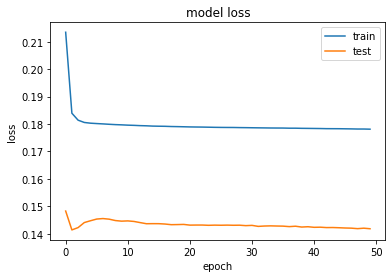

In [32]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K


model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid') )
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

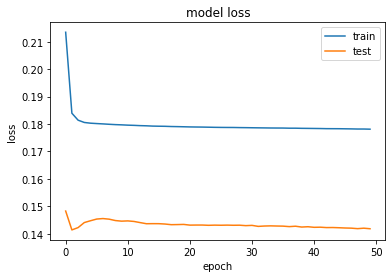

In [33]:
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [34]:
size = datafull.shape[1]
size

11

In [35]:
test_y.reshape((len(test_y))).shape

(78774,)

In [36]:
#test_x = test_x.reshape((test_x.shape[0], size))
#test_y = test_y.reshape((len(test_y), 1))

scores = model.evaluate(test_x, test_y, verbose=0)
print("F1-Score: %.2f%%" % (scores[1]*100))

pred =  model.predict(test_x)

F1-Score: 99.00%
2462/2462 [==============================] - 3s 1ms/step


In [37]:
def get_confusion_mat( y_true , y_pred):
    """
    Function to plot confusion matrix
    """
    # counfusion matrix
    confusion_mat = confusion_matrix(y_true , y_pred)
        
    labels = ["Broken", "Normal"]

    # plot heat map of confusion matrix
    sns.heatmap(confusion_mat, annot=True, fmt='', cmap='Greens',
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [297]:
get_confusion_mat(test_y, pred)

ValueError: continuous is not supported

In [313]:
pred

array([[0.00901443],
       [0.00888398],
       [0.00905844],
       ...,
       [0.899867  ],
       [0.9024158 ],
       [0.9025468 ]], dtype=float32)

In [130]:
size = datafull.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
#rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)

2022-10-06 21:30:59.855578: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 2. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[sequential_5/lstm_5/PartitionedCall]] [Op:__inference_predict_function_667113]

In [128]:
f1_macro = f1_score(inv_y, inv_yhat, average='macro')
f1_macro

ValueError: continuous is not supported

In [109]:
inv_y.shape

(90319,)

In [108]:
inv_yhat.shape

(90319,)